In [2]:
import torch
import torch.nn as nn
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform

torch.manual_seed(0)

2024-05-14 13:25:07.755325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 13:25:07.755498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 13:25:08.011452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load (and normalize) MNIST dataset

In [10]:
(trainX, trainY), (testX, testy) = load_data()
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

# Prior distributions

In [ ]:
class StandardGaussianDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = MultivariateNormal(torch.zeros(data_dim, device=device), torch.eye(data_dim, device=device))

    def log_pdf(self, z):
        return torch.sum(self.m.log_prob(z))

    def sample(self):
        return self.m.sample()

In [4]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return torch.sum(self.m.log_prob(z), dim=1)

    def sample(self):
        return self.m.sample()


# NICE model

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=512):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, data_dim // 2), nn.Tanh()) for i in range(5)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = torch.add(x_i2, self.m[i](x_i1))
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.multiply(torch.exp(self.s), x)
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x


def training(normalizing_flow, optimizer, dataloader, distribution, nb_epochs=1500, device='cpu'):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):

        for batch in dataloader:
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

    return training_loss


# Training and data generation

In [5]:
device = 'cuda'

100%|██████████| 10/10 [03:00<00:00, 18.04s/it]


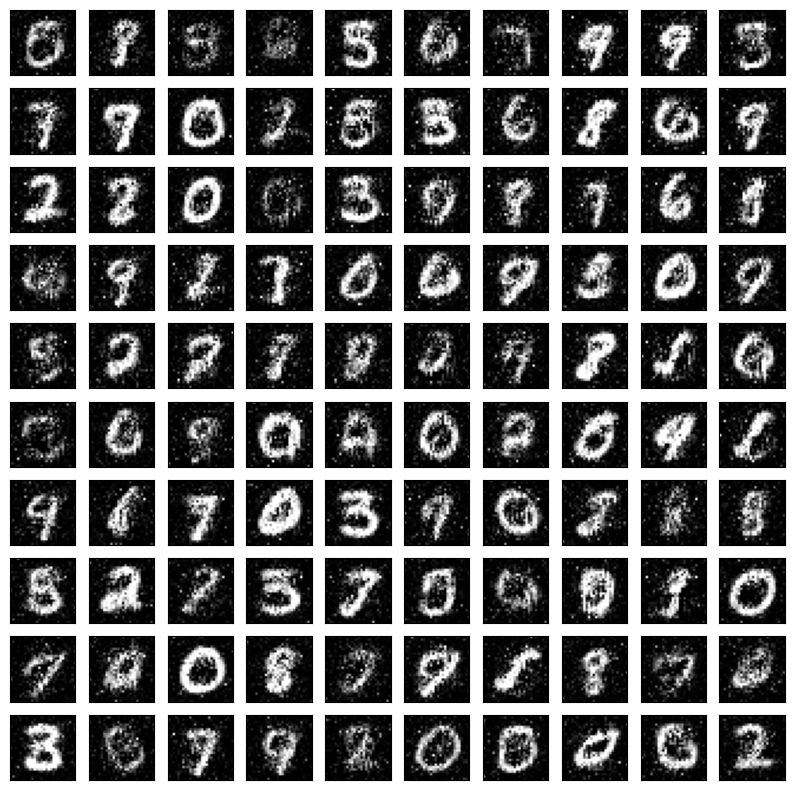

In [92]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)
assert torch.allclose(normalizing_flow.invert(normalizing_flow(x)[0]), x, rtol=1e-04, atol=1e-06)
optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)
training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, nb_epochs=10,
                         device=device)

nb_data = 10
fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
for i in range(nb_data):
    for j in range(nb_data):
        x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.savefig('./Generated_MNIST_data_6_Lin_LeakyReLU_Lin_Tanh_100_epochs_256_hid_dim.png')
plt.show()


# Saving model and loss

In [14]:
torch.save(normalizing_flow, "NICE_100_epochs_6_Lin_LeakyReLU_Lin_Tanh_256_hid_dim.pth")

In [15]:
with open("training_loss_NICE_100_epochs_5_Lin_LeakyReLU_Lin_Tanh_256_hid_dim.txt", mode="w") as f:
    for i in training_loss:
        f.write(str(i))
        f.write("\n")

# Inpainting (failure)

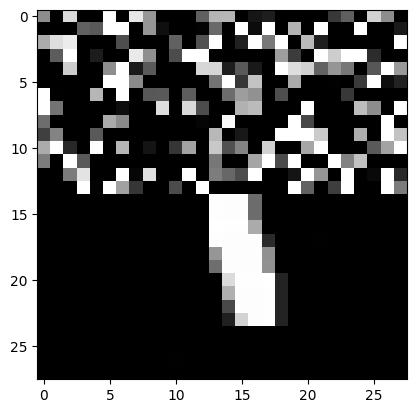

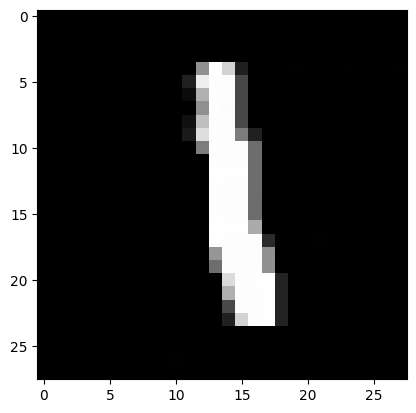

In [19]:
x_original = trainX[17].to(device)
x_masked = torch.clone(x_original)
x_masked[:(28 * 28 // 2)] = torch.randn(28 * 28 // 2, device=device)
plt.imshow(x_masked.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')
plt.show()
plt.imshow(x_original.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')
# normalizing_flow = torch.load("/kaggle/input/nice-trained/NICE_300_epoch.pth")
distribution = StandardLogisticDistribution(device=device)

/tmp/ipykernel_34/1752408913.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)


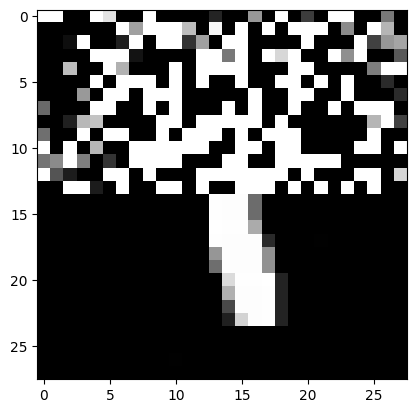

In [31]:
for i in range(10000):
    alpha = 10 / (100 + i)
    masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)
    z, log_jacobian = normalizing_flow(torch.cat((masked_part, x_masked[28 * 28 // 2:])).unsqueeze(0).to(device))
    log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
    masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device)) + torch.randn(28 * 28 // 2, device=device)
    x_masked[:(28 * 28 //2)] = masked_part
    
# plt.imshow(x_masked.reshape(28, 28).clip(0, 1), cmap='gray')
plt.imshow(x_masked.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')


# Inpainting (success)

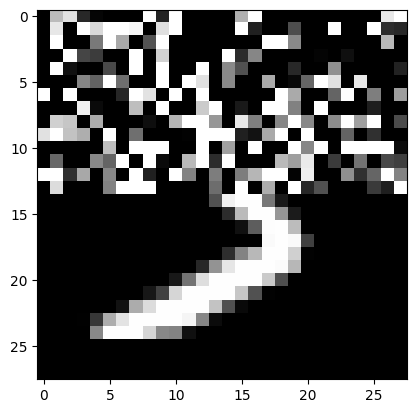

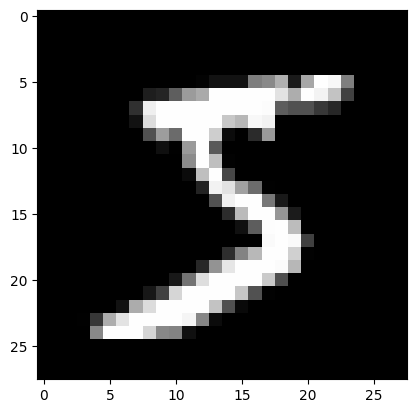

In [62]:
x_original = trainX[0].to(device)
x_masked = torch.clone(x_original)
x_masked[:(28 * 28 // 2)] = torch.randn(28 * 28 // 2, device=device)
plt.imshow(x_masked.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')
plt.show()
plt.imshow(x_original.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')
normalizing_flow = torch.load("/kaggle/input/nice-models/models/gaussian_prior_100_epochs")
# distribution = StandardLogisticDistribution(device=device)

/tmp/ipykernel_34/709655422.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)


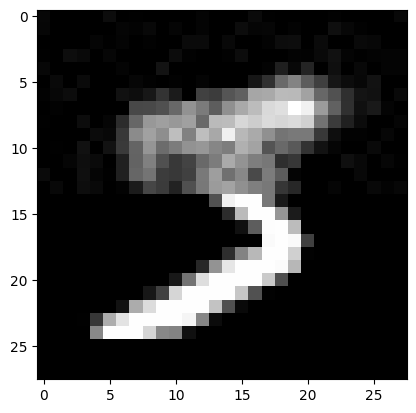

In [64]:
for i in range(2000):
    alpha = 10 / (100 + i)
    masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)
    z, log_jacobian = normalizing_flow(torch.cat((masked_part, x_masked[28 * 28 // 2:])).unsqueeze(0).to(device))
    log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
    masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
    x_masked[:(28 * 28 //2)] = masked_part
    
# plt.imshow(x_masked.reshape(28, 28).clip(0, 1), cmap='gray')
plt.imshow(x_masked.reshape(28, 28).clip(0, 1).cpu().detach().numpy(), cmap='gray')

# Different types of masking

In [ ]:
normalizing_flow = torch.load("/kaggle/input/nice-models/models/gaussian_prior_100_epochs")
distribution = StandardLogisticDistribution(device=device)

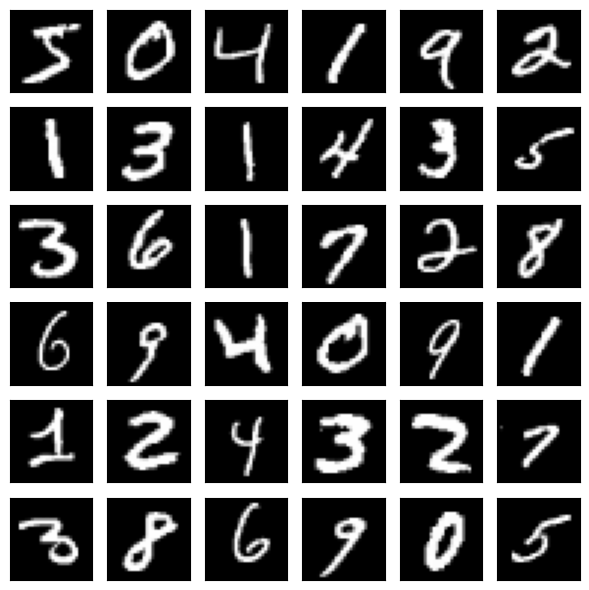

In [143]:
nb_data = 6
fig, axs = plt.subplots(nb_data, nb_data, figsize=(6, 6))
for i in range(6):
    for j in range(6):
        x = trainX[i * nb_data + j]
        axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()
plt.savefig('./original_numbers.png')
plt.show()

In [121]:
masked_images_array = []
for i in range(6):
    for j in range(6):
        masked_image = trainX[i * nb_data + j].clone().to(device)
        if i * 6 + j < 6:
            masked_image[:(28 * 28 // 2)] = torch.randn(28 * 28 // 2, device=device)
        elif 6 <= i * 6 + j < 12:
            masked_image[(28 * 28 // 2):] = torch.randn(28 * 28 // 2, device=device)
        elif 12 <= i * 6 + j < 18:
            masked_image[1::2] = torch.randn(28 * 28 // 2, device=device)
        elif 18 <= i * 6 + j < 24:
            masked_image[::2] = torch.randn(28 * 28 // 2, device=device)
        elif 24 <= i * 6 + j < 30:
            masked_image = masked_image.reshape(28, 28)
            masked_image[:, :14] = torch.randn(28, 14, device=device)  
            masked_image = masked_image.reshape(-1, 28 * 28)
        elif 30 <= i * 6 + j < 36:
            masked_image = masked_image.reshape(28, 28)
            masked_image[:, 14:] = torch.randn(28, 14, device=device)  
            masked_image = masked_image.reshape(-1, 28 * 28)

        masked_images_array.append(masked_image)
#         axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])


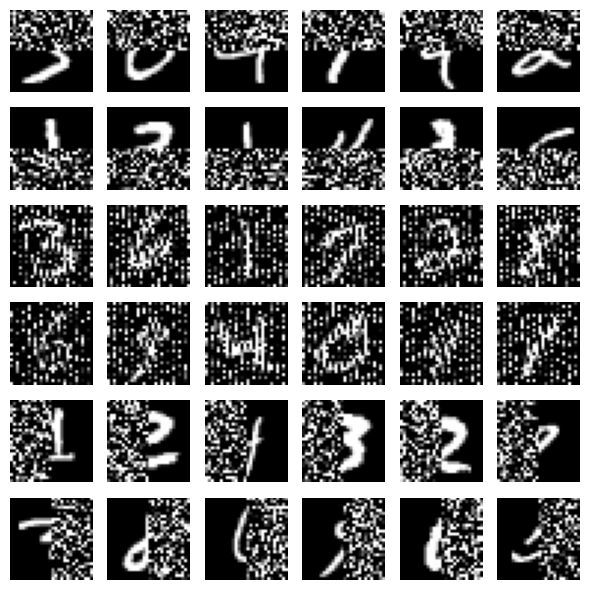

In [93]:
nb_data = 6
fig, axs = plt.subplots(nb_data, nb_data, figsize=(6, 6))
for i in range(nb_data):
    for j in range(nb_data):
        axs[i, j].imshow(masked_images_array[i * nb_data + j].reshape(28, 28).clip(0, 1).cpu(), cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.savefig("./masked_images.png")
plt.show()

In [ ]:
results_of_painting_100_epochs = []

for i in range(6):
    for j in range(6):
        print(i, j)
        print("image", i * 6 + j)
        x_masked = masked_images_array[i * 6 + j].clone().to(device)
        if i * 6 + j < 6:
            for k in range(2000):
                alpha = 10 / (100 + k)
                masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)
                z, log_jacobian = normalizing_flow(torch.cat((masked_part, x_masked[28 * 28 // 2:])).unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
                x_masked[:(28 * 28 //2)] = masked_part
        elif 6 <= i * 6 + j < 12:
            for k in range(2000):
                alpha = 10 / (100 + k)
                masked_part = torch.tensor(x_masked[28 * 28 // 2:], requires_grad=True)
                z, log_jacobian = normalizing_flow(torch.cat((x_masked[:28 * 28 // 2], masked_part)).unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
                x_masked[(28 * 28 //2):] = masked_part        
        elif 12 <= i * 6 + j < 18:
            for k in range(2000):
                alpha = 10 / (100 + k)
                masked_part = torch.tensor(x_masked[1::2], requires_grad=True)
                temporary = torch.zeros_like(x_masked)
                temporary[::2] = x_masked[::2]
                temporary[1::2] = masked_part
                z, log_jacobian = normalizing_flow(temporary.unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
                x_masked[1::2] = masked_part    
        elif 18 <= i * 6 + j < 24:
            for k in range(2000):
                alpha = 10 / (100 + k)
                masked_part = torch.tensor(x_masked[::2], requires_grad=True)
                temporary = torch.zeros_like(x_masked)
                temporary[1::2] = x_masked[1::2]
                temporary[::2] = masked_part
                z, log_jacobian = normalizing_flow(temporary.unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
                x_masked[::2] = masked_part    
        elif 24 <= i * 6 + j < 30:
            for k in range(2000):
                alpha = 10 / (100 + k)
                x_masked = x_masked.reshape(28, 28)
                masked_part = torch.tensor(x_masked[:, :14], requires_grad=True).flatten()
                temporary = torch.zeros_like(x_masked)
                temporary[:, :14] = masked_part.reshape(28, 14)
                temporary[:, 14:] = x_masked[:, 14:]
                z, log_jacobian = normalizing_flow(temporary.flatten().unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part.to(device))[0] + torch.randn(28 * 28 // 2, device=device))
                masked_part = masked_part.reshape(28, 14)
                x_masked[:, :14] = masked_part  
                x_masked = x_masked.reshape(-1, 28 * 28)

        elif 30 <= i * 6 + j < 36:
            for k in range(2000):
                alpha = 10 / (100 + k)
                x_masked = x_masked.reshape(28, 28)
                masked_part = torch.tensor(x_masked[:, 14:], requires_grad=True).flatten()
                temporary = torch.zeros_like(x_masked)
                temporary[:, 14:] = masked_part.reshape(28, 14)
                temporary[:, :14] = x_masked[:, :14]
                z, log_jacobian = normalizing_flow(temporary.flatten().unsqueeze(0).to(device))
                log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
                masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part.to(device))[0] + torch.randn(28 * 28 // 2, device=device))
                masked_part = masked_part.reshape(28, 14)
                x_masked[:, 14:] = masked_part  
                x_masked = x_masked.reshape(-1, 28 * 28)

        results_of_painting_100_epochs.append(x_masked)


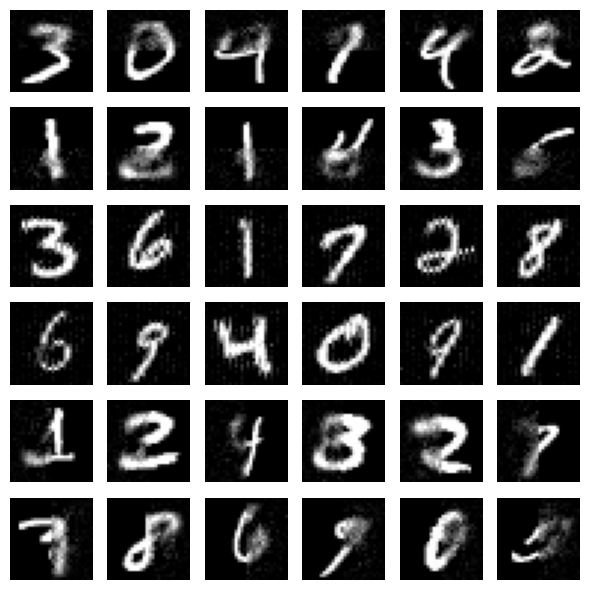

In [142]:
nb_data = 6
fig, axs = plt.subplots(nb_data, nb_data, figsize=(6, 6))
for i in range(nb_data):
    for j in range(nb_data):
        axs[i, j].imshow(results_of_painting_100_epochs[i * nb_data + j].reshape(28, 28).clip(0, 1).detach().cpu(), cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.savefig("./results_100_epochs.png")
plt.show()

## Inpainting results for different models

In [52]:
images = trainX[:9].to(device)
masked_images = images.clone()
for i in range(9):
    masked_images[i][:(28 * 28 // 2)] = torch.randn(28 * 28 // 2, device=device)

In [53]:
import os

model_files = os.listdir("/kaggle/input/nice-models/models")

In [70]:
distribution = StandardLogisticDistribution(device=device)

In [ ]:
j = 0
results_inpainting = {}
for model_file in model_files:
    print("model:", model_file)
    results_inpainting[model_file] = []
    model = torch.load("/kaggle/input/nice-models/models/" + model_file)
    for masked_image in masked_images:
        print("masked_image", j)
        x_masked = masked_image.clone()
#         print(x_masked)
        for i in range(2000):
            alpha = 10 / (100 + i)
            masked_part = torch.tensor(x_masked[:28 * 28 // 2], requires_grad=True)
            z, log_jacobian = model(torch.cat((masked_part, x_masked[28 * 28 // 2:])).unsqueeze(0).to(device))
            log_likelihood = torch.add(distribution.log_pdf(z), log_jacobian)
            masked_part = masked_part + alpha * (torch.autograd.grad(outputs=log_likelihood, inputs=masked_part)[0].to(device) + torch.randn(28 * 28 // 2, device=device))
            x_masked[:(28 * 28 //2)] = masked_part
        results_inpainting[model_file].append(x_masked)
        j += 1

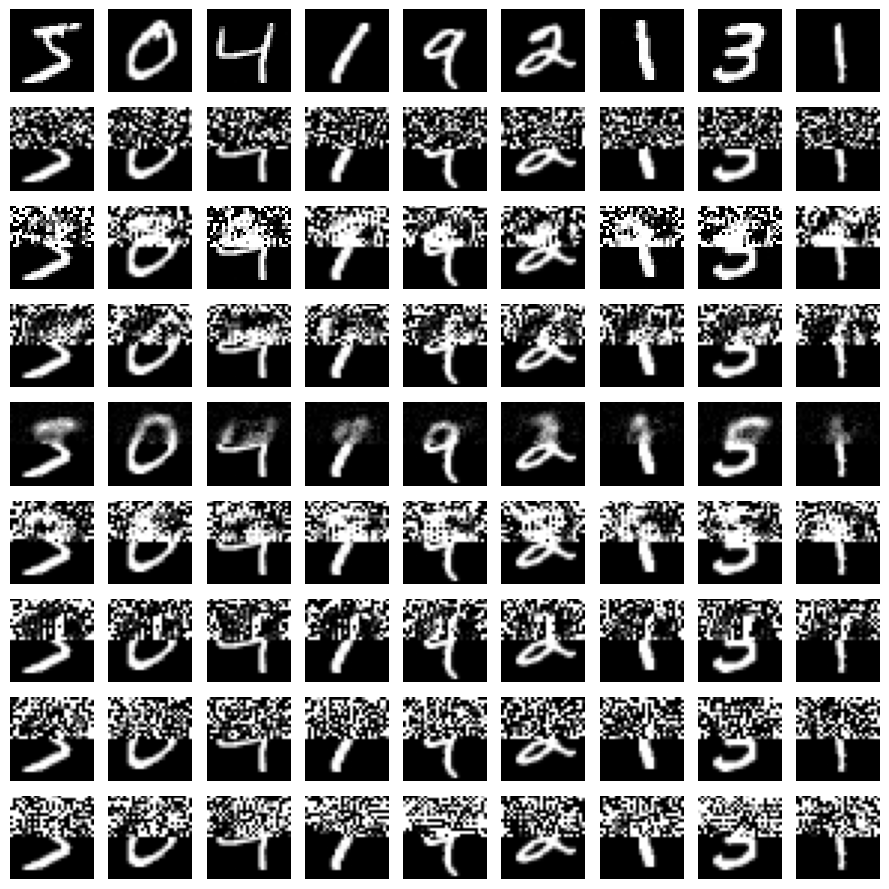

In [81]:
nb_data = 9
fig, axs = plt.subplots(nb_data, nb_data, figsize=(9, 9))

for i in range(nb_data):
    axs[0, i].imshow(images[i].reshape(28, 28).clip(0, 1).cpu(), cmap='gray')
    axs[0, i].axis('off')

    axs[1, i].imshow(masked_images[i].reshape(28, 28).clip(0, 1).cpu(), cmap='gray')
    axs[1, i].axis('off')

    j = 2
    for k in results_inpainting:
        axs[j, i].imshow(results_inpainting[k][i].reshape(28, 28).clip(0, 1).detach().cpu(), cmap='gray')
        axs[j, i].axis('off')

        j += 1
    
plt.tight_layout()
plt.savefig("results_of_inpainting.png")
plt.show()